In [12]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import glob
import pydicom
import cv2
import pickle
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.manifold import TSNE
import pickle

Prepares COVID Images as Inputs for Models.

In [2]:
COVID_PATH = 'data/binary/covid'
ENHANCED_COVID_PATH = 'data/binary/enhanced_covid'
FINAL_COVID_PATH = 'data/binary/final_covid'
NUM_COVID = 1000
COVID_SOURCES = ['kaggle_covid', 'github_covid', '10000_covid']
IMAGE_SIZE = (224, 224)

CLAHE Enhancing Reference

https://www.kaggle.com/seriousran/image-pre-processing-for-chest-x-ray?fbclid=IwAR0xYBmOLyPju9lelFGg0tKekpOmuoTu5haveUQsWrwRTS69Rj_hhymN1XE

In [4]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16, 16))
for source in COVID_SOURCES:
    num = 0
    for file_path in glob.glob(os.path.join(COVID_PATH, source) + '/*.jpeg'):
        img = cv2.imread(file_path, 0)
        img_clahe = clahe.apply(img)
        path = os.path.join(ENHANCED_COVID_PATH, source)
        cv2.imwrite('{}/{}_{}.jpeg'.format(path, source, num), img_clahe)
        num += 1

DataGenerator to rotate, shear, zoom, rescale, and fit input shape

In [5]:
datagen = ImageDataGenerator(rescale=1./255,
                             featurewise_center = True,
                             featurewise_std_normalization = True,
                             width_shift_range=0.05,
                             height_shift_range=0.05,
                             shear_range=0.1,
                             zoom_range=0.05,
                             zca_whitening = True,
                             channel_shift_range = 0,
                             horizontal_flip = True,
                             vertical_flip = False,
                             validation_split = 0.2,
                             fill_mode='constant')

processed_covid = datagen.flow_from_directory(ENHANCED_COVID_PATH,
                                               target_size=IMAGE_SIZE,
                                               shuffle=False,
                                               batch_size=NUM_COVID,
                                               class_mode="categorical")

Found 212 images belonging to 3 classes.


/Users/lcwong/opt/anaconda3/envs/py37/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:341: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


In [6]:
# Grabs the dataset in matrix format X:(212, 224, 224, 3), y:(212,)
def batch_and_label(processed):
    for x_batches, y_batches in processed:
        X, y = x_batches, y_batches
        break
    return X, y
X, y = batch_and_label(processed_covid)

/Users/lcwong/opt/anaconda3/envs/py37/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/Users/lcwong/opt/anaconda3/envs/py37/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [7]:
# Saves the final output images
for i in range(len(X)):
    plt.imsave(os.path.join(FINAL_COVID_PATH, 'covid_{}.jpeg'.format(i)), X[i])
    
# Save dataset
pickle.dump(X, open("pickled_data/covid.pkl", "wb" ) )

PCA to compare normal data from different sources

Source: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

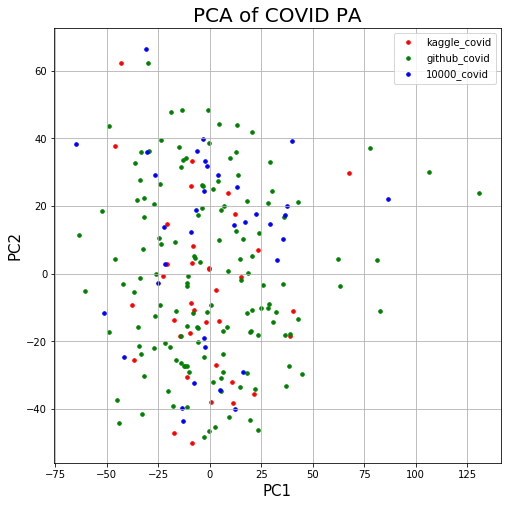

In [9]:
flatten_X = X.reshape([X.shape[0], -1])
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(flatten_X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
labels = list(map(lambda i:COVID_SOURCES[i], [list(i).index(1) for i in y]))
principalDf['target'] = labels

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('PCA of COVID PA', fontsize = 20)
targets = COVID_SOURCES
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['target'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'PC1']
               , principalDf.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50
               , marker = '.')
ax.legend(targets)
ax.grid()

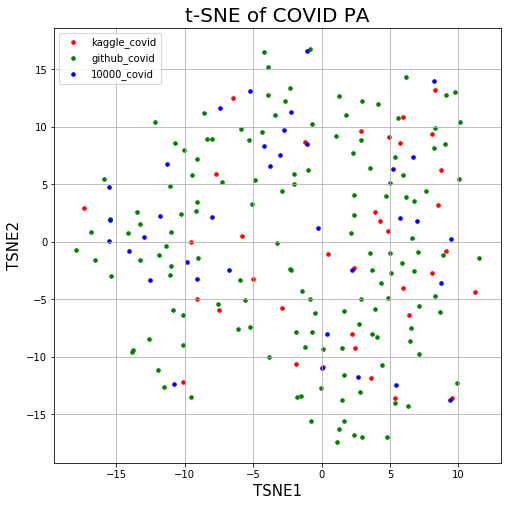

In [10]:
X_embedded = TSNE(n_components=2).fit_transform(flatten_X)
principalDf = pd.DataFrame(data = X_embedded, columns = ['TSNE1', 'TSNE2'])
labels = list(map(lambda i:COVID_SOURCES[i], [list(i).index(1) for i in y]))
principalDf['target'] = labels

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('TSNE1', fontsize = 15)
ax.set_ylabel('TSNE2', fontsize = 15)
ax.set_title('t-SNE of COVID PA', fontsize = 20)
targets = COVID_SOURCES
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['target'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'TSNE1']
               , principalDf.loc[indicesToKeep, 'TSNE2']
               , c = color
               , s = 50
               , marker = '.')
ax.legend(targets)
ax.grid()